In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [5]:
dataDir = '../data/cmsRD'
datasets_loc = []
# datasets_loc += glob(dataDir + '/ParkingBPH[12]/*B2JpsiKst_191002*')
# datasets_loc += glob(dataDir + '/ParkingBPH3/*B2JpsiKst_191003*')

datasets_loc += glob(dataDir + '/ParkingBPH1/*2018D-*B2JpsiKst_191017*')

In [6]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc)
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 8.8 fb^-1
Lumi analyzed: 21.3%


In [7]:
tree = rt.TChain('outA/Tevts')

for floc in datasets_loc:
   tree.Add(floc)

print 'N evts: {:.0f}'.format(tree.GetEntries())

N evts: 3408086


In [8]:
# f = datasets_loc[0]
# t = ur.open(f)['outA']['Tevts']
# # print tMC.keys(), '\n\n'
# branches = t.keys()
# for b in np.sort(branches):
# #     pass
#     print b

# d = extarct_multiple(datasets_loc, branches=branches, flag='data')
# print 'Number of events:', d['n_B'].shape[0]
# print 'Number of candidates:', d['mass_JpsiKst'].shape[0]

# Cuts declaration

In [9]:
cut_general = [
    'n_B == 1'
]

# Muon system

In [10]:
cut_mumu = [
####----- Trigger-like cuts -----#
'mum_pt > 3.5',
'mup_pt > 3.5',
'Jpsi_pt > 6.9',
# 'sigdxy_vtxJpsi_PV > 3', #useless
'pval_mumu > 0.1',
'mum_eta > -2.2',
'mup_eta > -2.2',
'mum_eta < 2.2',
'mup_eta < 2.2',
'cosT_Jpsi_PV > 0.95',
####----- Muon systems cuts -----#
'mum_dxy < 3',
'mup_dxy < 3',
]

In [11]:
cut_str = ' && '.join(cut_general + cut_mumu)
print cut_str

n_B == 1 && mum_pt > 3.5 && mup_pt > 3.5 && Jpsi_pt > 6.9 && pval_mumu > 0.1 && mum_eta > -2.2 && mup_eta > -2.2 && mum_eta < 2.2 && mup_eta < 2.2 && cosT_Jpsi_PV > 0.95 && mum_dxy < 3 && mup_dxy < 3


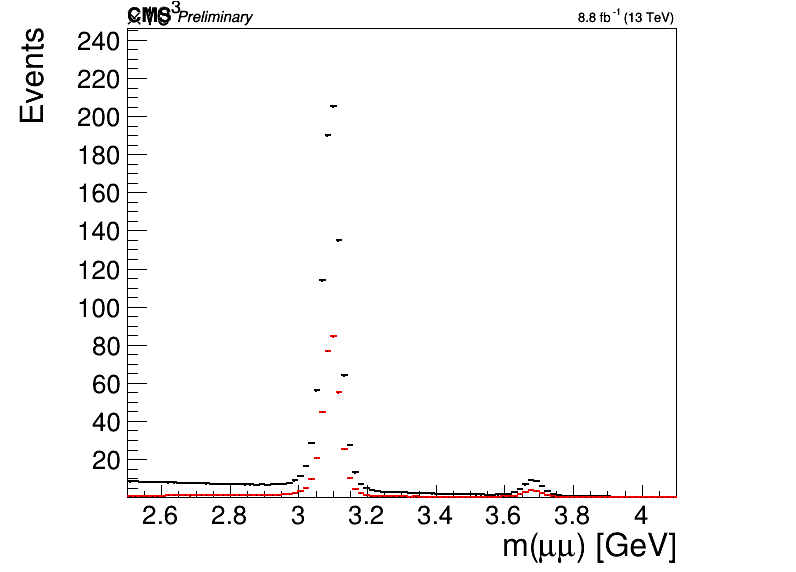

In [12]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[100, 2.5, 4.1]
               )
tree.Project('h', 'mass_mumu', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_mumu', cut_str + ' && pval_mumupiK > 0.1')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

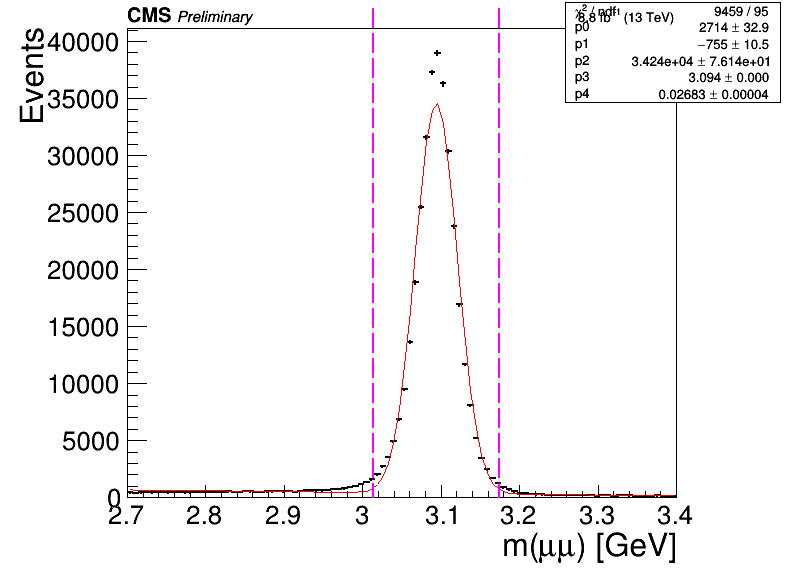

In [13]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[100, 2.7, 3.4]
               )
tree.Project('h', 'mass_mumu', cut_str + ' && pval_mumupiK > 0.1')
h.Sumw2()
f_fit = rt.TF1('f_fit', '[0] + x*[1] + gaus(2)', 2.7,3.4)
f_fit.SetParameter(0, h.GetBinContent(1))
f_fit.SetParameter(1, (h.GetBinContent(100) - h.GetBinContent(1))/(h.binning[2] - h.binning[1]))
f_fit.SetParameter(2, h.GetMaximum())
f_fit.SetParameter(3, 3.1)
f_fit.SetParameter(4, 0.05)
h.Fit(f_fit, 'LSRQ')

m_mumu_min = f_fit.GetParameter(3) - 3*f_fit.GetParameter(4)
m_mumu_max = f_fit.GetParameter(3) + 3*f_fit.GetParameter(4)

c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
cl.DrawLine(m_mumu_min, 0, m_mumu_min, 1.1*h.GetMaximum())
cl.DrawLine(m_mumu_max, 0, m_mumu_max, 1.1*h.GetMaximum())
c.Draw()

# Hadron system

In [14]:
cut_piK = [
####----- Hadron systems cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'K_sigdxy_PV > 2',
'pi_sigdxy_PV > 2',
'pval_piK > 0.1'
]

In [15]:
cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && K_pt > 0.8 && pi_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && pval_piK > 0.1


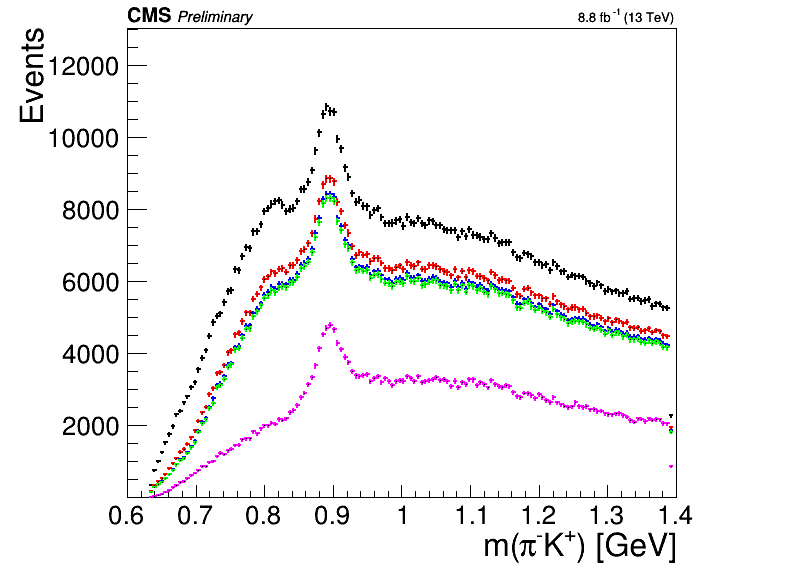

In [16]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[150, 0.6, 1.4]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tree.Project('h3', 'mass_piK', cut_str + ' && sigdxy_vtxKst_PV > 5')
h3.Sumw2()
h3.SetLineColor(rt.kBlue)

h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
tree.Project('h4', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5 && sigdxy_vtxKst_PV > 5')
h4.Sumw2()
h4.SetLineColor(rt.kGreen)

h5 = create_TH1D(np.zeros(0), name='h5', binning=h.binning)
tree.Project('h5', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5 && sigdxy_vtxKst_PV > 5 && pval_mumupiK > 0.1')
h5.Sumw2()
h5.SetLineColor(rt.kMagenta)

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3, h4, h5], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

In [17]:
cut_piK += [
    'sigdxy_vtxKst_PV > 5',
    'pval_mumupiK > 0.1'
]
cut_piK = list(dict.fromkeys(cut_piK))

cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && pval_piK > 0.1 && K_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && sigdxy_vtxKst_PV > 5 && pval_mumupiK > 0.1 && pi_pt > 0.8


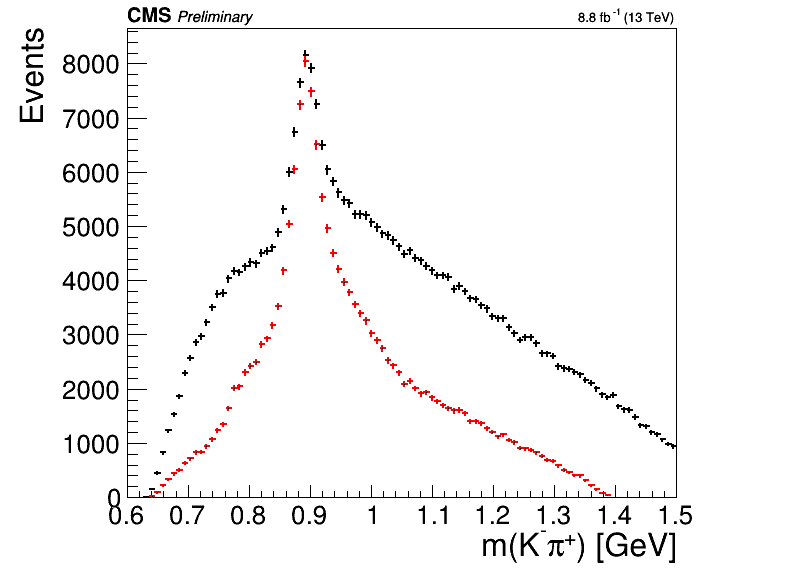

In [18]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(K^{-}#pi^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK_CPconj', cut_str)
h.Sumw2()

wrongCP_cut = 'fabs(mass_piK - 0.892) > fabs(mass_piK_CPconj - 0.892)'
h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK_CPconj', cut_str + ' && ' + wrongCP_cut)
h2.Sumw2()
h2.SetLineColor(rt.kRed)


                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

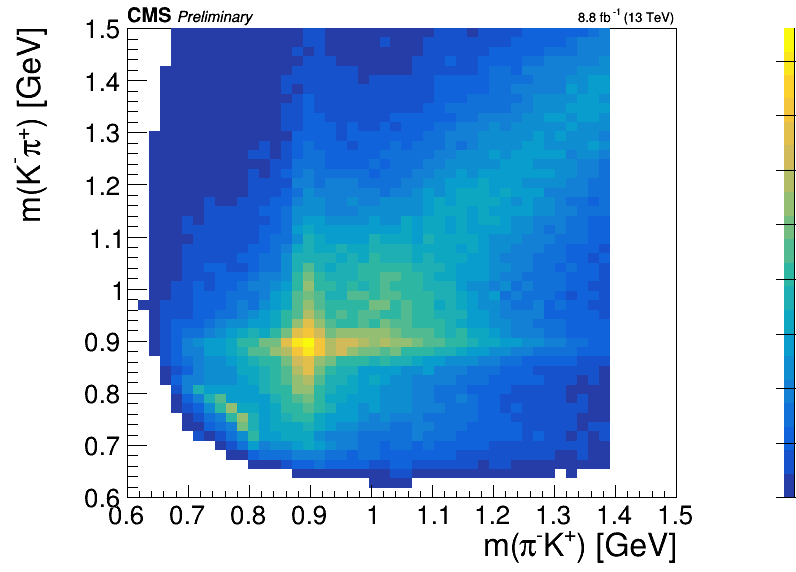

In [19]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'm(K^{-}#pi^{+}) [GeV]', 'Events'],
                binning=[50, 0.6, 1.5, 50, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK_CPconj:mass_piK', cut_str)
h.Sumw2()


                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

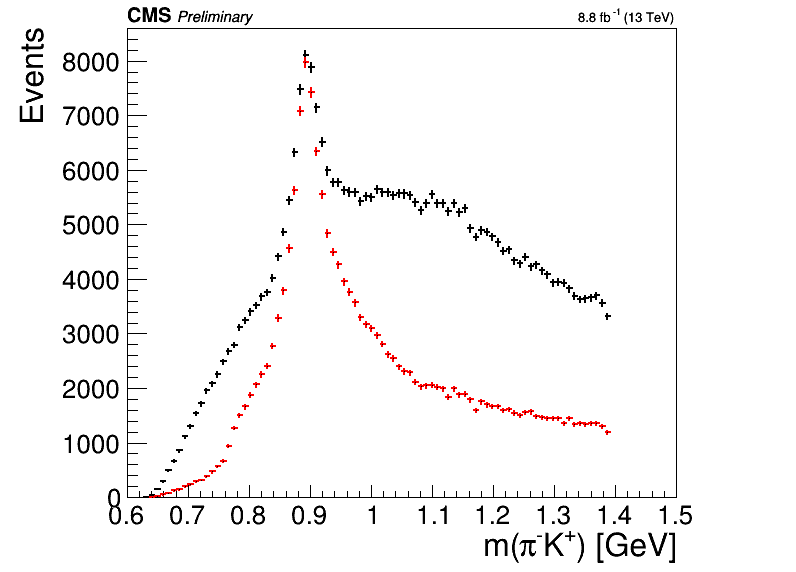

In [20]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

correctCP_cut = 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)'
h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && ' + correctCP_cut)
h2.Sumw2()
h2.SetLineColor(rt.kRed)


                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

In [21]:
cut_piK += ['fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)']
cut_piK = list(dict.fromkeys(cut_piK))

cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && pval_piK > 0.1 && K_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && sigdxy_vtxKst_PV > 5 && fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892) && pval_mumupiK > 0.1 && pi_pt > 0.8


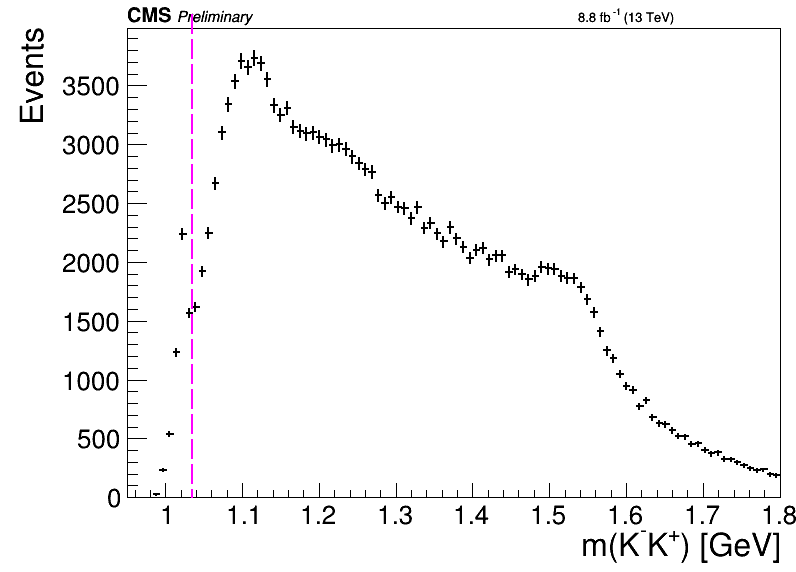

In [22]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(K^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.95, 1.8]
               )
tree.Project('h', 'mass_KK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
cl.DrawLine(1.035, 0, 1.035, 1.1*h.GetMaximum())
c.Draw()

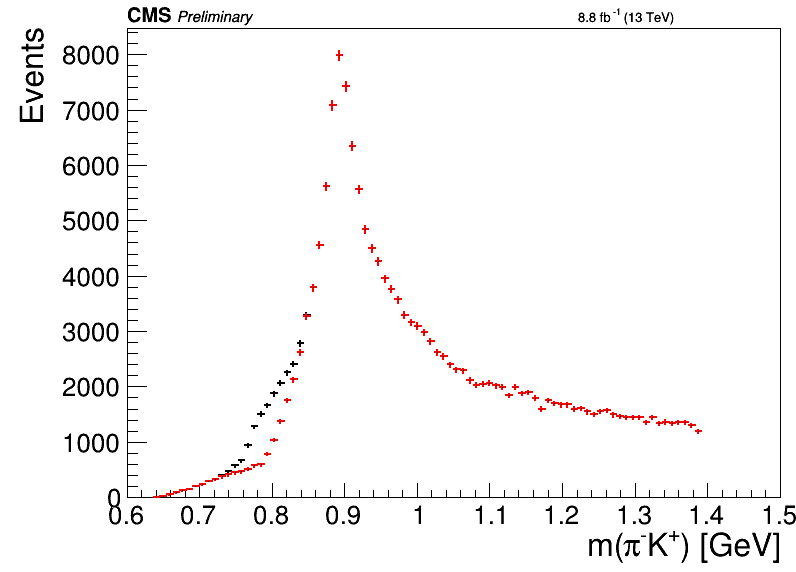

In [23]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && mass_KK > 1.035')
h2.Sumw2()
h2.SetLineColor(rt.kRed)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.Draw()

In [24]:
cut_piK += ['mass_KK > 1.035']
cut_piK = list(dict.fromkeys(cut_piK))
print cut_piK

['pval_piK > 0.1', 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)', 'mass_KK > 1.035', 'K_sigdxy_PV > 2', 'pi_sigdxy_PV > 2', 'sigdxy_vtxKst_PV > 5', 'K_pt > 0.8', 'pval_mumupiK > 0.1', 'pi_pt > 0.8']


# Full analysis

In [25]:
cut_B = [
    'mass_mumu < {:.3f}'.format(m_mumu_max),
    'mass_mumu > {:.3f}'.format(m_mumu_min),
    'mass_piK > 0.82',
    'mass_piK < 0.96'
        ]
cut_B += cut_mumu + cut_piK
print cut_B

cut_str = ' && '.join(cut_general + cut_B)

['mass_mumu < 3.174', 'mass_mumu > 3.013', 'mass_piK > 0.82', 'mass_piK < 0.96', 'mum_pt > 3.5', 'mup_pt > 3.5', 'Jpsi_pt > 6.9', 'pval_mumu > 0.1', 'mum_eta > -2.2', 'mup_eta > -2.2', 'mum_eta < 2.2', 'mup_eta < 2.2', 'cosT_Jpsi_PV > 0.95', 'mum_dxy < 3', 'mup_dxy < 3', 'pval_piK > 0.1', 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)', 'mass_KK > 1.035', 'K_sigdxy_PV > 2', 'pi_sigdxy_PV > 2', 'sigdxy_vtxKst_PV > 5', 'K_pt > 0.8', 'pval_mumupiK > 0.1', 'pi_pt > 0.8']


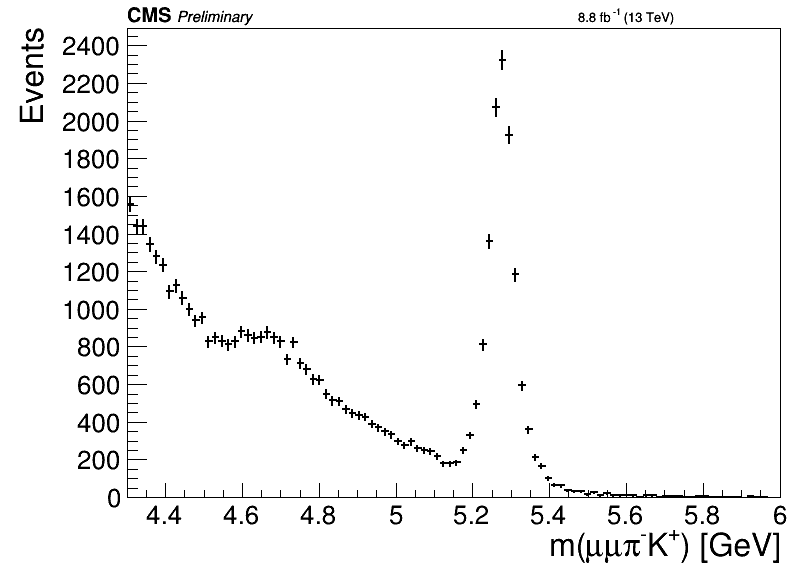

In [26]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 4.3, 6]
               )
tree.Project('h', 'mass_mumupiK', cut_str)
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

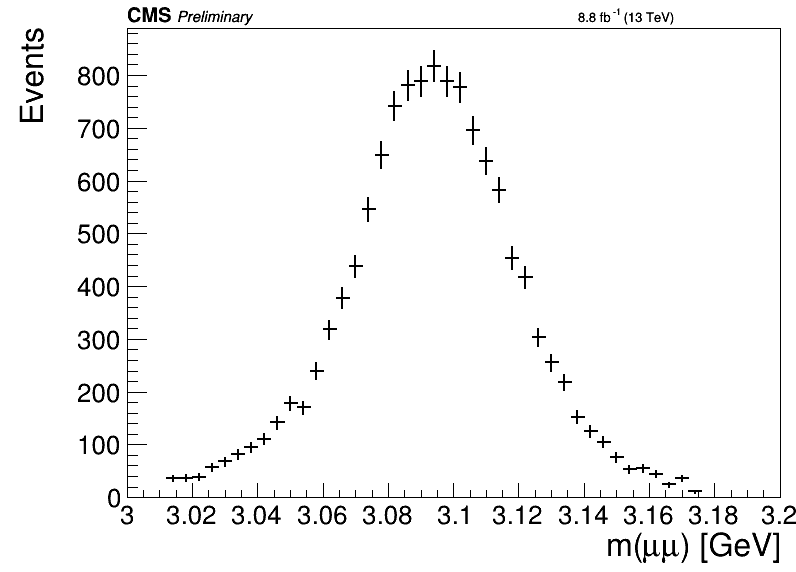

In [27]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[50, 3, 3.2]
               )
tree.Project('h', 'mass_mumu', cut_str + ' && mass_mumupiK < 5.45 && mass_mumupiK > 5.15')
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

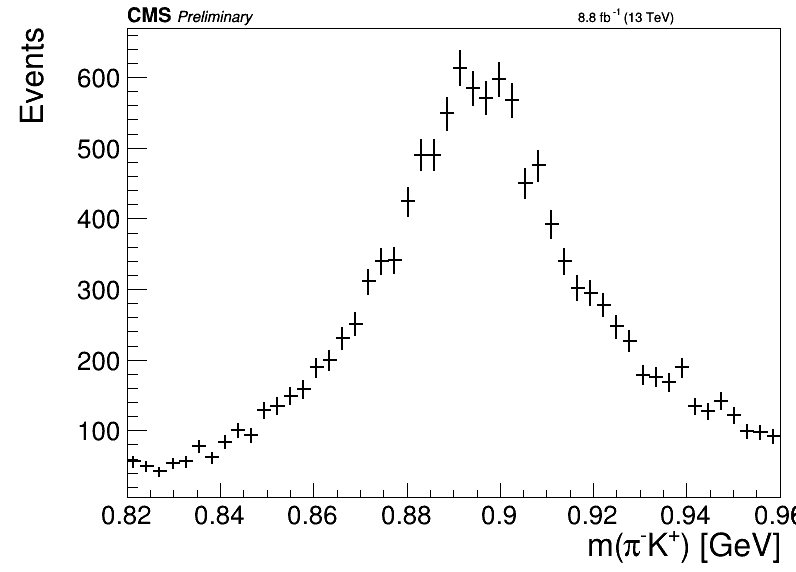

In [28]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[50, 0.82, 0.96]
               )
tree.Project('h', 'mass_piK', cut_str + ' && mass_mumupiK < 5.45 && mass_mumupiK > 5.15')
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

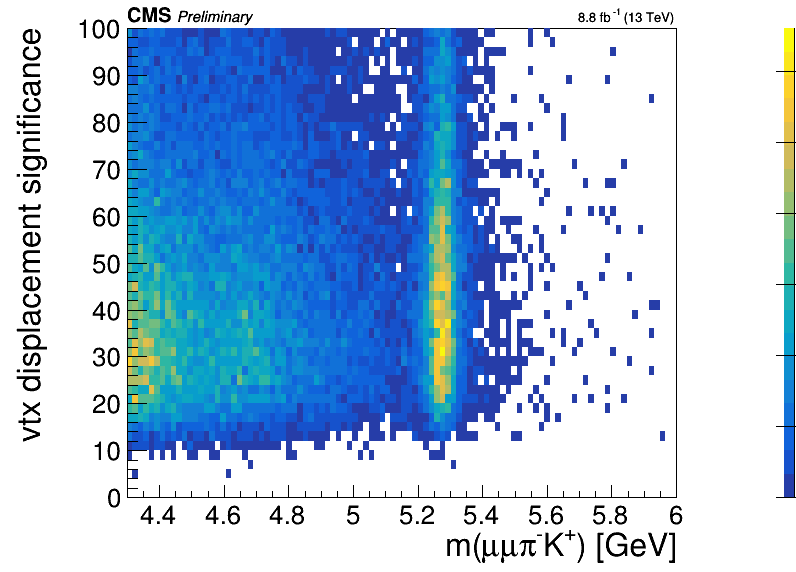

In [29]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'vtx displacement significance', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 100]
               )
tree.Project('h', 'sigd_vtxB_PV_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

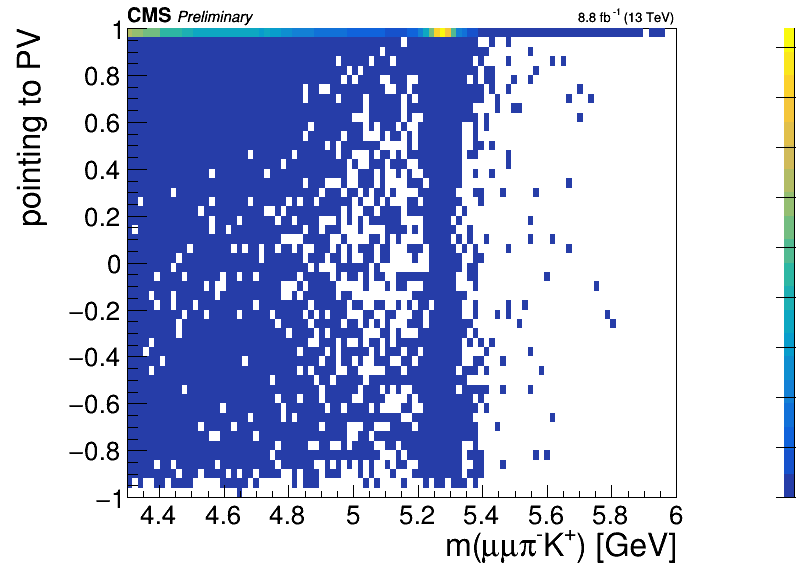

In [30]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'pointing to PV', 'Events'],
                binning=[100, 4.3, 6, 50, -1, 1]
               )
tree.Project('h', 'cos_B_PV_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

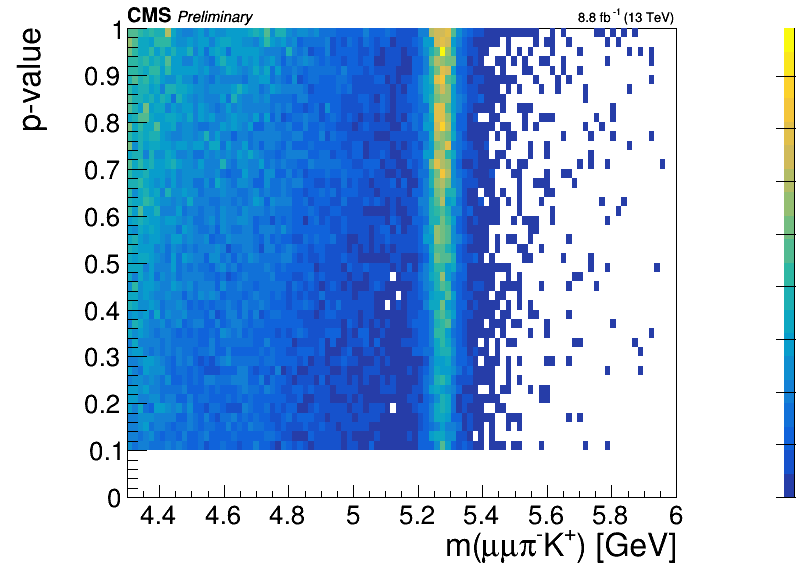

In [31]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'p-value', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 1]
               )
tree.Project('h', 'pval_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

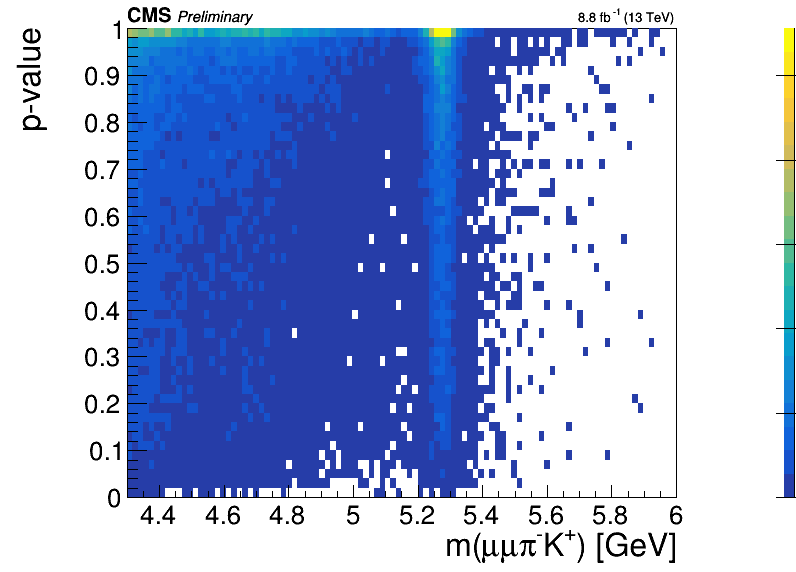

In [32]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'p-value', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 1]
               )
tree.Project('h', 'pval_mumupiKrefit:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

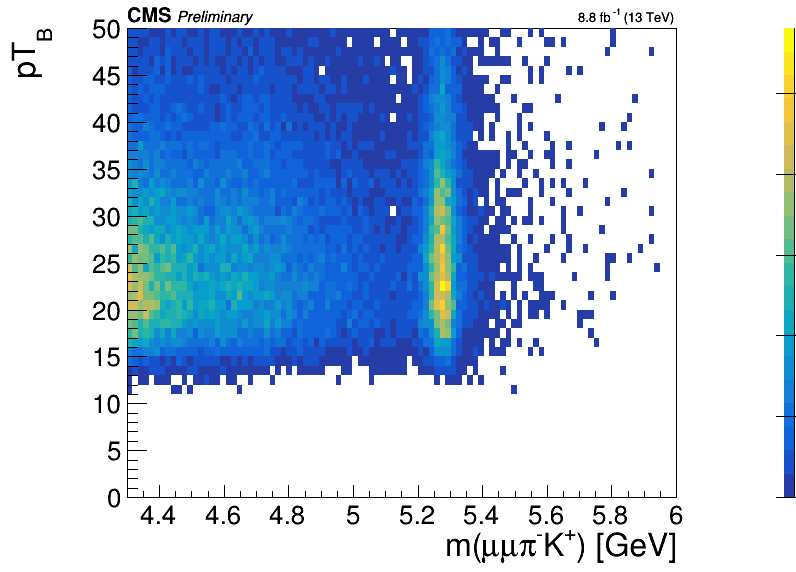

In [33]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'pT_{B}', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 50]
               )
tree.Project('h', 'B_mumupiK_pt:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

# Signal isolation

In [34]:
cut_str = ' && '.join(cut_B)
# cut_str = ' && '.join(cut_general + cut_B)

In [35]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[30, 5, 5.6]
               )
tree.Project('h', 'mass_mumupiK', cut_str)
h.Sumw2()

In [36]:
# tf = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst.root', 'r')
# skimmed_tree = tf.Get('Tevts')
# h = create_TH1D(np.zeros(0), name='h',
#                 title='',
#                 axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
#                 binning=[30, 5, 5.6]
#                )
# skimmed_tree.Project('h', 'mass_mumupiK')
# h.Sumw2()

In [37]:
N_tot = h.Integral(1, h.binning[0])
print N_tot
print h.Integral()

20573.0
20573.0


[WARNING] Chi2: 252.640201018 / 24
Total: Nsig = 13746, Nbkg = 6827
Sig region histo entries: 16174
Sig region: Nsig = 13709, Nbkg = 2465



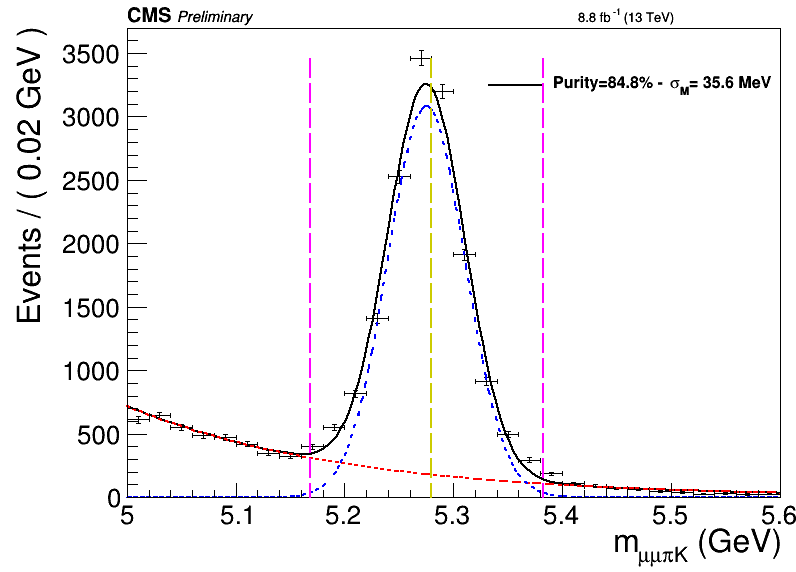

In [38]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')
frame = mass.frame(rf.Title(""))

mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# sigma_wide = rt.RooRealVar('sigma', '#sigma', 0.2, 0.00005, 0.1, 'GeV') 
# pdf_sig_wide = rt.RooGaussian('gausWide','sig pdf', m, mean, sigma_wide)

# fraction = rt.RooRealVar('fraction', 'f', 0.5, 0, 1, '')
# pdf_sig_2 = rt.RooAddPdf('doubleGauss', 'pdf_sig_2', mass, pdf_sig_wide, fraction)

nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)


lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)
# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 1000)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', m, rt.RooArgList(a0, a1, a2), 0)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
pdf_tot.fitTo(data, rt.RooFit.PrintLevel(-1))

chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
if chi2.getVal() > rt.TMath.ChisquareQuantile(0.95, h.binning[0]-1-5):
    print '[WARNING] Chi2:', chi2.getVal(), '/', h.binning[0]-1-5

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

lb = mean.getVal()-3*sigma.getVal()
hb = mean.getVal()+3*sigma.getVal()
print 'Sig region histo entries: {:.0f}'.format(h.Integral(h.FindBin(lb), h.FindBin(hb)))


Nsig = erf(3/np.sqrt(2)) * nsig.getVal()
Nbkg = h.Integral(h.FindBin(lb), h.FindBin(hb)) - Nsig
print 'Sig region: Nsig = {:.0f}, Nbkg = {:.0f}\n'.format(Nsig, Nbkg)

purity = Nsig/float(Nbkg+Nsig)

leg = rt.TLegend(0.6,0.75,0.98,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h, 'Purity={:.1f}% - #sigma_{{M}}= {:.1f} MeV'.format(purity*100, 1e3*sigma.getVal()), 'l')

c = drawOnCMSCanvas(CMS_lumi, frame)
m = mean.getVal()
res = sigma.getVal()
cl.SetLineColor(rt.kMagenta)
cl.DrawLine(m-3*res, 0, m-3*res, h.GetMaximum())
cl.DrawLine(m+3*res, 0, m+3*res, h.GetMaximum())

cl.SetLineColor(rt.kYellow+1)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum())

leg.Draw()

In [39]:
Bmass_cuts = ['mass_mumupiK > 5', 'mass_mumupiK < 5.6']
cut_B + Bmass_cuts

['mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 6.9',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5',
 'mass_mumupiK < 5.6']

In [40]:
output = []
N_accepted_cand = []

import operator
ops = {'>': operator.gt, '<': operator.lt, }

pb = ProgressBar(maxEntry=tree.GetEntries())
for i_ev, ev in enumerate(tree):
    pb.show(i_ev)
    N_acc = 0
    for j in range(ev.pval_mumupiK.size()):
        accept = abs(ev.mass_piK[j] - 0.892) < abs(ev.mass_piK_CPconj[j] - 0.892)
        for c_str in cut_B + Bmass_cuts:
            if c_str == 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)': continue
            if not accept:
                break
            aux = c_str.split(' ')
            if len(aux) != 3:
                raise
            x = getattr(ev, aux[0])[j]
            accept = ops[aux[1]](x, float(aux[2]))
        if accept:
            N_acc += 1
            output.append((ev.mass_mumupiK[j], ev.B_mumupiK_pt[j], ev.B_mumupiK_eta[j]))
    if N_acc > 0:
        N_accepted_cand.append(N_acc)

print len(output)
dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
print dic

[####################]  100% - Tot. time: 330.3 s
20573
{1: 20496, 2: 37, 3: 1}


In [41]:
import root_numpy as rtnp
dtypes = [('mass_mumupiK', np.float32), ('B_pt', np.float32), ('B_eta', np.float32)]
a = np.array(output, dtype=dtypes)
skimmed_tree = rtnp.array2tree(a)
rtnp.array2root(a, '../data/cmsRD/skimmed/B2JpsiKst.root', treename='Tevts', mode='RECREATE')

In [42]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', skimmed_tree, rt.RooArgSet(mass, v_B_eta, v_B_pt))#, v_B_eta))

In [43]:
# fr = mass.frame(rf.Title(""))
# # fr = v_B_pt.frame(rf.Title(""))
# # fr = v_B_eta.frame(rf.Title(""))

# ds.plotOn(fr)
# c = drawOnCMSCanvas(CMS_lumi, fr)

In [44]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))

In [45]:
t = ds.tree()
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst.root', 'RECREATE')
t.Write()
f_sw.Close()